In [2]:
import torch

# 获取激活样本
def choice_sample(s_id:int, l_id:int, attn:bool, t_id:int, model:str='Llama-2-7b-hf'):
    # assert model in ['Llama-2-7b-hf', 'Meta-Llama-3-8B'], 'model should be Llama-2-7b-hf or Meta-Llama-3-8B.'
    assert s_id in range(0, 128), 's_id should be in range(0, 148)'
    assert l_id in range(0, 32), 'l_id should be in range(0, 32)'
    assert t_id in range(0, 2048), 't_id should be in range(0, 2048)'
    path = f'/home/shaoyuantian/program/RLLM/data/train_data/wikitext2_128samples/{model}/r1_train/'
    block = 'self_attn_q_proj' if attn else 'mlp_up_proj'
    sample = torch.load(f'{path}sample_{s_id}_layer_{l_id}_{block}.pt',
                       map_location='cpu').float()
    token = sample[t_id]
    return token, sample

# 计算激活的峰度
def kurtosis(sample, g):
    if g>0:
        sample = sample.view(-1, sample.shape[-1]//g, g)
    else:
        sample = sample.view(-1, sample.shape[-1])
    mean = sample.mean(dim=-1, keepdim=True)
    std = sample.std(dim=-1, keepdim=True)
    sample = (sample - mean) / std
    kurtosis = ((sample ** 4).mean(dim=-1, keepdim=True) - 3) / (std ** 4)
    return kurtosis

    
# 计算激活的偏度
def skewness(sample, g):
    sample = sample.flatten()
    mean = sample.mean()
    std = sample.std()
    sample = (sample - mean) / std
    skewness = ((sample ** 3).mean()) / (std ** 3)
    return skewness

# 计算激活的均值
def mean(sample, g):
    if g>0:
        sample = sample.view(-1, sample.shape[-1]//g, g)
    else:
        sample = sample.view(-1, sample.shape[-1])
    return sample.mean(dim=-1)

# 绘制激活的直方图，并标注峰度和均值作为图例
def plot_hist(sample, title:str):
    import matplotlib.pyplot as plt
    sample = sample.flatten()
    plt.hist(sample, bins=100, alpha=0.7)
    plt.title(title)
    plt.legend([f'kurtosis: {kurtosis(sample):.2f}, mean: {mean(sample):.2f}'])
    plt.show()

In [ ]:
import sys
sys.path.append('/home/shaoyuantian/program/MixedPrecision/fake_quant/')

from rotation_utils import get_orthogonal_matrix

#  随机选取n个 meta-llama/Llama-2-7b-hf 激活样本，统计n个样本的平均峰度和平均均值
def stat_random(n:int, model:str='Llama-2-7b-hf', r:str='hadamard', r_g:int=16):
    import random
    kurtosis_list = [[],[],[],[]]
    mean_list = [[],[],[],[]]
    # if r in ['random', 'hadamard']: 
    #     rot = get_orthogonal_matrix(4096, r, 'cpu').float()
    # elif r == 'cube_had':
    #     rot = get_orthogonal_matrix([r_g, 4096], r, 'cpu').float()
    # else:
    #     rot = torch.eye(4096, device='cpu')
    for i in range(n):
        s_id = random.randint(0, 127)
        l_id = random.randint(0, 31)
        t_id = random.randint(0, 2047)
        attn = random.choice([True, False])
        token, sample = choice_sample(s_id, l_id, attn, t_id, model)
        rot = get_orthogonal_matrix(4096, 'hadamard', 'cpu').float()
        token_r = token @ rot
        # print(f'token shape: {token.shape}, sample shape: {sample.shape}')
        kurtosis_list[0].append(kurtosis(token_r, r_g))
        mean_list[0].append(mean(token_r, r_g))
        rot = get_orthogonal_matrix([16, 4096], 'cube_had', 'cpu').float()
        token_r = token @ rot
        kurtosis_list[1].append(kurtosis(token_r, r_g))
        mean_list[1].append(mean(token_r, r_g))
        rot = get_orthogonal_matrix(4096, 'random', 'cpu').float()
        token_r = token @ rot
        kurtosis_list[2].append(kurtosis(token_r, r_g))
        mean_list[2].append(mean(token_r, r_g))
        rot = get_orthogonal_matrix([16, 4096], 'cube_random', 'cpu').float()
        token_r = token @ rot
        kurtosis_list[3].append(kurtosis(token_r, r_g))
        mean_list[3].append(mean(token_r, r_g))
    print(f'hadamsrd: {sum(kurtosis_list[0]) / n}, {sum(mean_list[0]) / n}')
    print(f'cube_had: {sum(kurtosis_list[1]) / n}, {sum(mean_list[1]) / n}')
    print(f'random: {sum(kurtosis_list[2]) / n}, {sum(mean_list[2]) / n}')
    print(f'cube_random: {sum(kurtosis_list[3]) / n}, {sum(mean_list[3]) / n}')

/home/shaoyuantian/anaconda3/envs/mixpre/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
stat_random(1000, model='Llama-2-7b-hf', r='hadamard', r_g=16)

hadamsrd: tensor([[[-0.9859],
         [-1.0814],
         [-1.0712],
         [-1.1179],
         [-1.0969],
         [-1.0163],
         [-1.1339],
         [-0.9920],
         [-1.0724],
         [-1.0824],
         [-0.9331],
         [-1.0539],
         [-0.9357],
         [-1.0489],
         [-1.0884],
         [-1.0382],
         [-0.9985],
         [-1.0376],
         [-1.0252],
         [-0.9371],
         [-0.9970],
         [-0.9684],
         [-1.0665],
         [-1.0872],
         [-1.0444],
         [-1.0161],
         [-1.1156],
         [-1.0505],
         [-1.1306],
         [-1.0157],
         [-1.0217],
         [-1.1651],
         [-0.9895],
         [-1.2584],
         [-0.9698],
         [-0.9137],
         [-1.1122],
         [-1.0402],
         [-1.0229],
         [-1.1080],
         [-1.0833],
         [-1.0372],
         [-0.9464],
         [-1.1259],
         [-1.0672],
         [-0.9369],
         [-1.0627],
         [-1.0479],
         [-1.0031],
         [

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_3d_matrix(org_w,
                   title='3D Matrix Visualization',
                   xlabel='input',
                   ylabel='output',
                   zlabel='Intensity',
                   cmap='coolwarm'):
    """
    将输入的矩阵进行 3D 可视化。

    参数:
    org_w: 2D numpy 数组 或 torch.Tensor，表示要可视化的矩阵
    xlabel: X 轴的标签
    ylabel: Y 轴的标签
    zlabel: Z 轴的标签
    cmap: 颜色映射，默认 'coolwarm'
    """
    # 如果输入是 torch.Tensor，转换为 numpy.ndarray
    if isinstance(org_w, torch.Tensor):
        org_w = org_w.numpy()

    # 确保输入是二维矩阵
    if not isinstance(org_w, np.ndarray) or org_w.ndim != 2:
        raise ValueError("org_w 必须是一个二维矩阵（numpy array 或 torch tensor）。")

    M, N = org_w.shape
    X = np.arange(N)
    Y = np.arange(M)
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 绘制 3D 表面图
    ax.plot_surface(X, Y, org_w, cmap=cmap)

    # 设置坐标轴标签
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.title.set_text(f'{title}')

    plt.show()

In [ ]:
def stat_sample(n:int, model:str='Llama-2-7b-hf', r:str='hadamard', r_g:int=16):
    import random
    kurtosis_list = [[],[],[],[]]
    mean_list = [[],[],[],[]]
    s_id = random.randint(0, 127)
    l_id = random.randint(0, 31)
    t_id = random.randint(0, 2047)
    attn = random.choice([True, False])
    token, sample = choice_sample(s_id, l_id, attn, t_id, model)
    rot = get_orthogonal_matrix(4096, 'hadamard', 'cpu').float()
    token_r = sample @ rot
    plot_3d_matrix(token_r.abs(), f'hadamard: {s_id}, {l_id}, {t_id}, {attn}')
    # print(f'token shape: {token.shape}, sample shape: {sample.shape}')
    kurtosis_list[0].append(kurtosis(token_r, r_g))
    mean_list[0].append(mean(token_r, r_g))
    rot = get_orthogonal_matrix([16, 4096], 'cube_had', 'cpu').float()
    token_r = sample @ rot
    plot_3d_matrix(token_r.abs(), f'cube_had: {s_id}, {l_id}, {t_id}, {attn}')
    kurtosis_list[1].append(kurtosis(token_r, r_g))
    mean_list[1].append(mean(token_r, r_g))
    rot = get_orthogonal_matrix(4096, 'random', 'cpu').float()
    token_r = sample @ rot
    plot_3d_matrix(token_r.abs(), f'random: {s_id}, {l_id}, {t_id}, {attn}')
    kurtosis_list[2].append(kurtosis(token_r, r_g))
    mean_list[2].append(mean(token_r, r_g))
    rot = get_orthogonal_matrix([16, 4096], 'cube_random', 'cpu').float()
    token_r = sample @ rot
    plot_3d_matrix(token_r.abs(), f'cube_random: {s_id}, {l_id}, {t_id}, {attn}')
    kurtosis_list[3].append(kurtosis(token_r, r_g))
    mean_list[3].append(mean(token_r, r_g))
    print(f'hadamard: {torch.stack(kurtosis_list[0]).mean()}, {torch.stack(mean_list[0]).mean()}')
    print(f'cube_had: {torch.stack(kurtosis_list[1]).mean()}, {torch.stack(mean_list[1]).mean()}')
    print(f'random: {torch.stack(kurtosis_list[2]).mean()}, {torch.stack(mean_list[2]).mean()}')
    print(f'cube_random: {torch.stack(kurtosis_list[3]).mean()}, {torch.stack(mean_list[3]).mean()}')

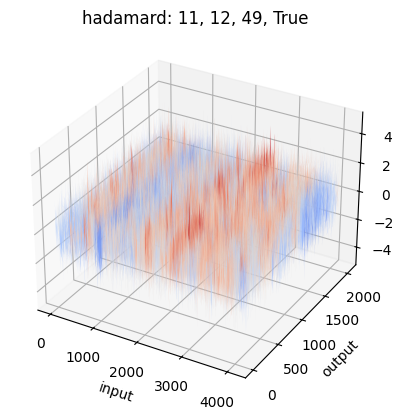

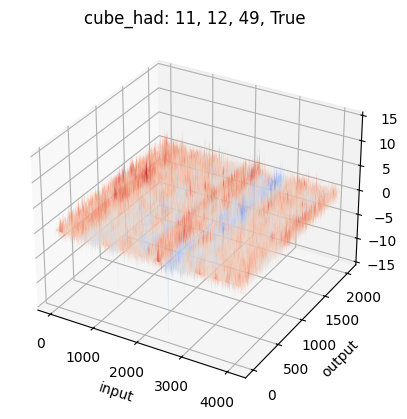

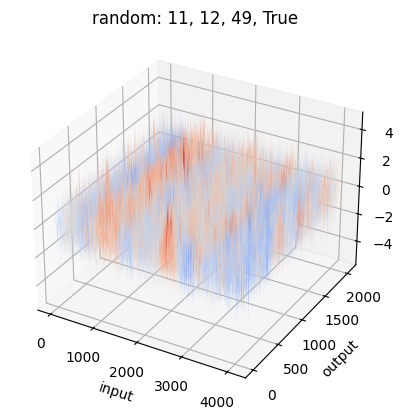

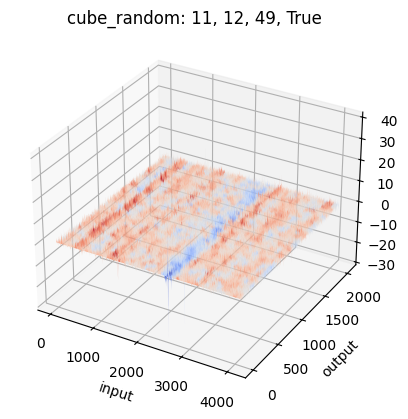

hadamard: -1.0413700342178345, -0.0003606474492698908
cube_had: -1589.78076171875, -0.003556369338184595
random: -1.0552338361740112, -0.003919658251106739
cube_random: -1201.4794921875, -0.007617039605975151


In [18]:
stat_sample(1000, model='Llama-2-7b-hf', r='cube_had', r_g=16)

In [ ]:
stat_random(100, model='Llama-2-7b-hf', r='hadamard', r_g=-1)

In [ ]:
# 各个模型的激活样本的平均峰度和平均均值
num = 500
mean_kurtosis, mean_mean = stat_random(num, 'Llama-2-7b-hf')
print(f"Llama-2-7b {num}个样本的平均峰度 {mean_kurtosis:.2f}, 平均均值 {mean_mean:.2e}")
mean_kurtosis, mean_mean = stat_random(num, 'Meta-Llama-3-8B')
print(f"Meta-Llama-3-8B {num}个样本的平均峰度 {mean_kurtosis:.2f}, 平均均值 {mean_mean:.2e}")
mean_kurtosis, mean_mean = stat_random(num, 'Llama-2-13b-hf')
print(f"Llama-2-13b {num}个样本的平均峰度 {mean_kurtosis:.2f}, 平均均值 {mean_mean:.2e}")
mean_mean_kurtosis, mean_mean = stat_random(num, 'Meta-Llama-3-70B')
print(f"Meta-Llama-3-70B {num}个样本的平均峰度 {mean_kurtosis:.2f}, 平均均值 {mean_mean:.2e}")
kurtosis, mean_mean = stat_random(num, 'Llama-2-70b-hf')
print(f"Llama-2-70b {num}个样本的平均峰度 {mean_kurtosis:.2f}, 平均均值 {mean_mean:.2e}")